## Prototype for Signature Detection

### Design

- 1- Grayscale Image
- 2- Threshold with Binary inversion and OTSU 
- 3- Remove Horizontal Lines and Vertical Lines
- 4- Identify all regions with connected lines of a certain size (customizable threshold)
- 5- List all detected signatures and bounding boxes

Here is a sample visual output:

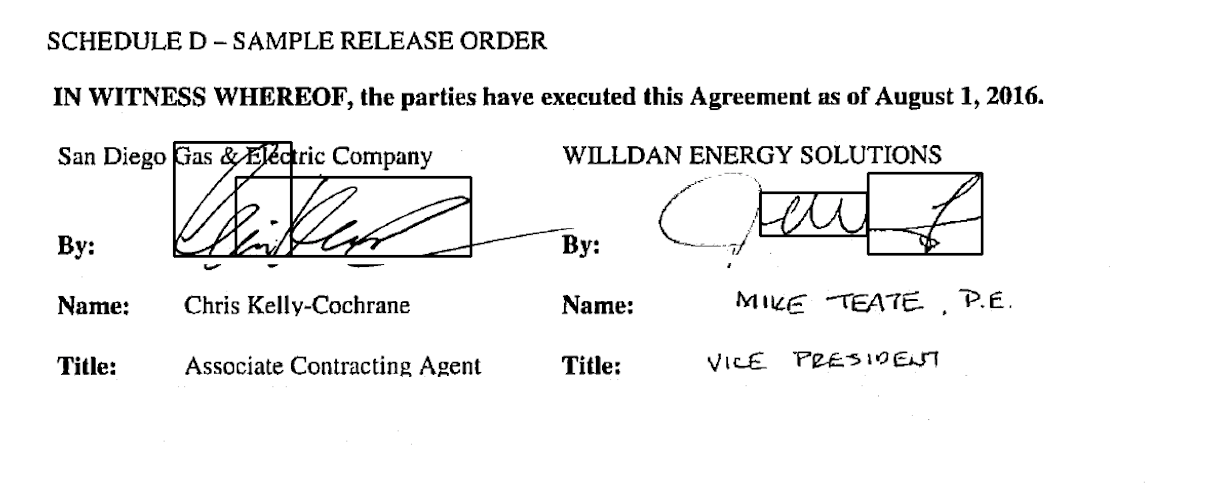

Number of Signatures detected:4


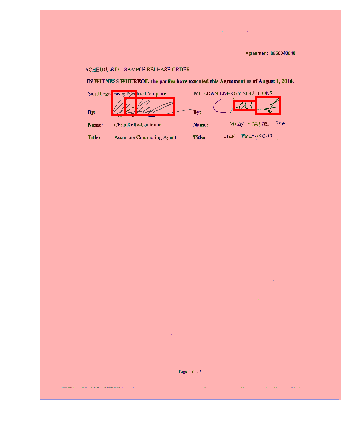

True

In [4]:
import cv2
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.color import label2rgb
from skimage.measure import regionprops
import matplotlib.patches as mpatches

INPUTIMAGE = './inputs/signatures/in5.png'

# Defines the output of openCV calls
class CVOutput:
    def __init__(self,image,error):
        self.image = image
        self.error = error
        
class SignatureItem:
    def __init__(self,minr,minc,maxr,maxc):
        self.minr = minr
        self.minc = minc
        self.maxr = maxr
        self.maxc = maxc

#######
# MAIN
#######

MIN_CONNECTED_THRESHOLD = 680
MAX_CONNECTED_THRESHOLD = 8000
DebugMode = True

# Open image as grayscale
image = cv2.imread(INPUTIMAGE,cv2.IMREAD_GRAYSCALE)

# We NEED thresholding to remove vertical and horizontal lines
thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image, [c], -1, (255,255,255), 5)
     
# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image, [c], -1, (255,255,255), 5)


ObjOut = CVOutput(image,None)
img = ObjOut.image

# Uncomment the following line to create an image without lines       
#cv2.imwrite("./inputs/out5.png",ObjOut.image)

# connected component analysis by scikit-learn framework
blobs = img > img.mean()
blobs_labels = measure.label(blobs, background=1)
image_label_overlay = label2rgb(blobs_labels, image=img)

fig, ax = plt.subplots(figsize=(10, 6))

the_biggest_component = 0

AllSignatures = []

for region in regionprops(blobs_labels):

    if (region.area >= MIN_CONNECTED_THRESHOLD and region.area < MAX_CONNECTED_THRESHOLD):
        if (region.area > the_biggest_component):
            the_biggest_component = region.area
            
        minr, minc, maxr, maxc = region.bbox
        signature = SignatureItem(minr, minc, maxr, maxc)
        #print("debug:"+str(minr))
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        AllSignatures.append(signature)
    
print("Number of Signatures detected:" + str(len(AllSignatures)))

if(DebugMode == True):
    ax.imshow(image_label_overlay)  
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


for s in AllSignatures:

    img_mod= cv2.rectangle(img,(s.minc,s.minr),(s.maxc,s.maxr),(0, 0, 255), 2)
    
cv2.imwrite("./inputs/signatures/out5_final.png",img_mod)

# TO DO: This method would improve big time if we merged overlapping bounding boxes
